## SVD, PCA & Robust PCA

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.image import imread
from jupyterthemes import jtplot
#jtplot.style(theme="grade3", context="notebook", ticks=True, grid=True)
jtplot.style(theme="monokai", context="notebook", ticks=True, grid=True)
import scipy.io

There is *yale-b-faces* picture stored. Use the SciPy function loadmat to load the
data and inspect it.<br>
Next, we update the sizes and fontsizes of the figures in this notebook.

In [2]:
plt.rcParams['figure.figsize'] = [9, 9]
plt.rcParams.update({'font.size': 16})

Now we load the Yale faces B mat-file *yale-b-faces.mat* with the help of scipy and store the data into the matrix *all_faces*. The dataset contains 2410 images of size $192 \times 168$ of 38 different people. The number of images per person is stored in the vector *number_of_faces_per_person*.

In [3]:
mat_file_import = scipy.io.loadmat('yale-b-faces.mat')
all_faces = mat_file_import['faces']
number_of_faces_per_person = mat_file_import['nfaces'].reshape(-1)

all_faces.shape

(32256, 2410)

Before we start processing the data, we write a couple of helper functions for the following exercise. The function *standardise* and *de_standardise* will allow column-wise standardisation of a matrix _matrix_. The function soft_shrinkage performs the component-wise soft shrinkage
$$ \text{soft}_{\alpha}(f) = \text{sign}(f) \max( |f | - \alpha, 0) , $$
where $\alpha$ is denoted by *regularisation_parameter* and the input $f$ by *input_vector*. The function *nuclear_norm_proximal_mapping* computes the solution of 
$$ \arg\min_{M \in \mathbb{R}^{n \times s}} \left\{ \frac12 \| M - X \|^2_{\text{Fro}} + \alpha \| M \|_\ast \right\} , $$
which is nothing but the soft-thresholding of the singular values. Here $\alpha$ is also denoted by *regularisation_parameter* and the input $X$ is known as _matrix_.

In [4]:
def standardise(matrix):
    means = np.mean(matrix, axis=0)
    matrix = matrix - means
    stds = np.std(matrix, axis=0)
    return matrix / stds, means, stds

def de_standardise(matrix, means, stds):
    matrix = matrix * stds
    return matrix + means

def soft_shrinkage(input_vector, regularisation_parameter=1):
    return np.sign(input_vector) * np.clip(np.abs(input_vector) - regularisation_parameter, \
                                           a_min=0, a_max=np.inf)

def nuclear_norm_proximal_mapping(matrix, regularisation_parameter=1):
    U, S, V_transpose = np.linalg.svd(matrix, full_matrices=0)
    return U @ np.diag(soft_shrinkage(S, regularisation_parameter)) @ V_transpose

Next, we store all standardised face images of the first person in a data matrix *matrix*, $X \in \mathbb{R}^{32256x64}$

(32256, 64)


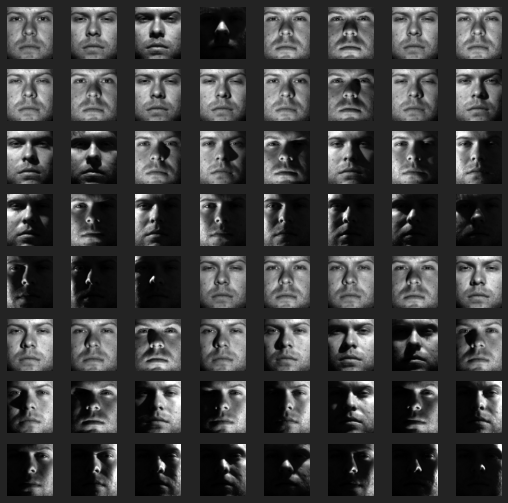

In [6]:
matrix, means, stds = standardise(all_faces[:,:number_of_faces_per_person[0]])
print(matrix.shape)
for counter in range(number_of_faces_per_person[0]):
    plt.subplot(8, 8, counter + 1)
    plt.imshow(matrix[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout   
plt.show()

## SVD/PCA

First, we compute and visualise the covariance matrix of $X$.

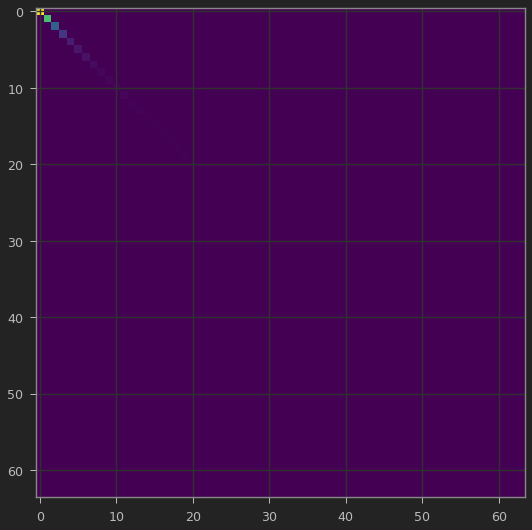

In [7]:
U, S, V_transpose = np.linalg.svd(matrix, full_matrices=0)
test1 = U.T @ matrix
test2 = test1 @ test1.T
plt.imshow(test2)
plt.show()

Now we compute different PCA approximations of $X$ via $X_k = U_k U_k^T X$, where $U_k \in \mathbb{R}^{32256\,x\,k}$ are 
the first $k$ columns of the matrix $U$ from the SVD $X=U\Sigma V^T$. In particualar, compute the approximation for $k=29$
and the difference between $X$ and $X_k$ in the Frobenius norm.

125.85629796563248


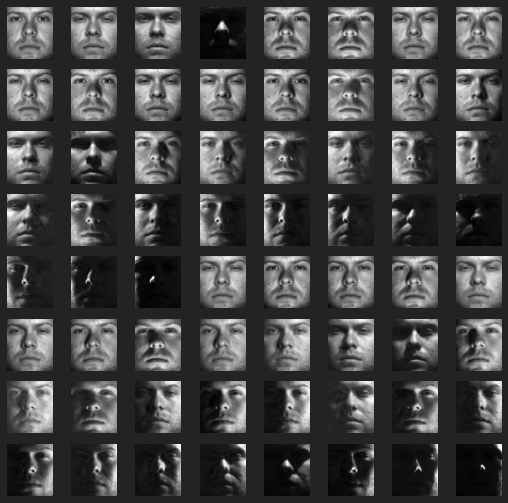

In [8]:
approximation_index = 29
U_approximation = U[:, 0:approximation_index]
approximated_matrix = U_approximation @ (U_approximation.T @ matrix)
print(np.linalg.norm(approximated_matrix - matrix, 'fro'))
#plt.imshow(approximated_matrix[:, 7].reshape((168, 192)).T, cmap='gray')
for counter in range(number_of_faces_per_person[0]):
    plt.subplot(8, 8, counter + 1)
    plt.imshow(approximated_matrix[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout
plt.show()

## Robust PCA and Accelerated Robust PCA
Let's implement the robust PCA for parameters $\tau=1$, $\gamma=10$, $\alpha=\sqrt{192\,x\,168}$ and compute matrices $L^k$ and $S^k$, where $K$ denotes the terminal iteration index. We choose $K$ such that either the loss
$\frac{1}{2}\|L^k+S^k-X\|^2_{Fro}$ satisfies $\frac{1}{2}\|L^k+S^k-X\|^2_{Fro} \leq \frac{10^{-8}}{2}\|X\|^2_{Fro}$, or if it exceeds a maxiumum number of iterations $K_{max}=1500$.<br>
For the Accelerated Robust PCA, we chhose the sequence $\{\beta_k\}_{k=0}^K$ such that {\beta_0=0} and $\beta_k=(k-1)(k+3)$
for $k>0$.

In [14]:
def robust_pca(matrix, regularisation_parameters=np.nan, maximum_no_iterations=1500, tolerance=np.nan, \
               acceleration=False):
    rows, columns = matrix.shape

    if np.isnan(regularisation_parameters):
        regularisation_parameters = 10*np.array([np.sqrt(np.maximum(rows, columns)), 1])

    if np.isnan(tolerance):
        tolerance = 10**(-8) * (np.linalg.norm(matrix, 'fro') ** 2)/2
        
    low_rank_matrix = np.zeros_like(matrix)
    sparse_matrix = np.zeros_like(matrix)
    full_matrix = matrix
    previous_full_matrix = matrix
    
    step_size = 0.5
    adaptive_step_size = 0
    counter = 0
    sensitivity = 1/2 * np.linalg.norm(matrix, 'fro') ** 2
    sensitivities = []
    sensitivities.append(sensitivity)
    
    while (sensitivity > tolerance) and (counter < maximum_no_iterations):
        argument = (1 + adaptive_step_size) * full_matrix - adaptive_step_size * \
                                previous_full_matrix
        low_rank_matrix = nuclear_norm_proximal_mapping(step_size * argument, \
                                                        regularisation_parameters[0])
        sparse_matrix = soft_shrinkage(step_size * argument, regularisation_parameters[1])  
        
        previous_full_matrix = full_matrix
        
        residual = low_rank_matrix + sparse_matrix - matrix
        
        full_matrix = argument - residual
        
        sensitivity = 1/2 * np.linalg.norm(residual, 'fro') ** 2
        sensitivities.append(sensitivity)
        counter += 1
        
        if counter % 50 == 0:
            print('Iteration [%d/%d], sensitivity: %.4f/%.4f' 
                   %(counter, maximum_no_iterations, sensitivity, tolerance))
            
        if acceleration == True:
            adaptive_step_size = (counter - 1)/(counter + 3)
            
    print('Completed after iteration [%d/%d], sensitivity: %.4f/%.4f' 
                   %(counter, maximum_no_iterations, sensitivity, tolerance))
        
    return low_rank_matrix, sparse_matrix, sensitivities

In [10]:
L, S, sensitivities = robust_pca(matrix)

Iteration [50/1500], sensitivity: 9761.4775/0.0103
Iteration [100/1500], sensitivity: 2918.0399/0.0103
Iteration [150/1500], sensitivity: 1481.0259/0.0103
Iteration [200/1500], sensitivity: 902.4338/0.0103
Iteration [250/1500], sensitivity: 563.1444/0.0103
Iteration [300/1500], sensitivity: 387.9300/0.0103
Iteration [350/1500], sensitivity: 275.3229/0.0103
Iteration [400/1500], sensitivity: 213.1771/0.0103
Iteration [450/1500], sensitivity: 158.4012/0.0103
Iteration [500/1500], sensitivity: 127.5269/0.0103
Iteration [550/1500], sensitivity: 103.6438/0.0103
Iteration [600/1500], sensitivity: 81.5860/0.0103
Iteration [650/1500], sensitivity: 68.0996/0.0103
Iteration [700/1500], sensitivity: 57.2956/0.0103
Iteration [750/1500], sensitivity: 47.2966/0.0103
Iteration [800/1500], sensitivity: 39.6793/0.0103
Iteration [850/1500], sensitivity: 34.1111/0.0103
Iteration [900/1500], sensitivity: 29.5501/0.0103
Iteration [950/1500], sensitivity: 25.7556/0.0103
Iteration [1000/1500], sensitivity: 2

/tmp/ipykernel_30932/3641850974.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  figure.colorbar(image1, ax=axis1[0])
/tmp/ipykernel_30932/3641850974.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  figure.colorbar(image2, ax=axis1[1])
/tmp/ipykernel_30932/3641850974.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  figure.colorbar(image3, ax=axis2[0])
/tmp/ipykernel_30932/3641850974.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

28 18789.04386776001


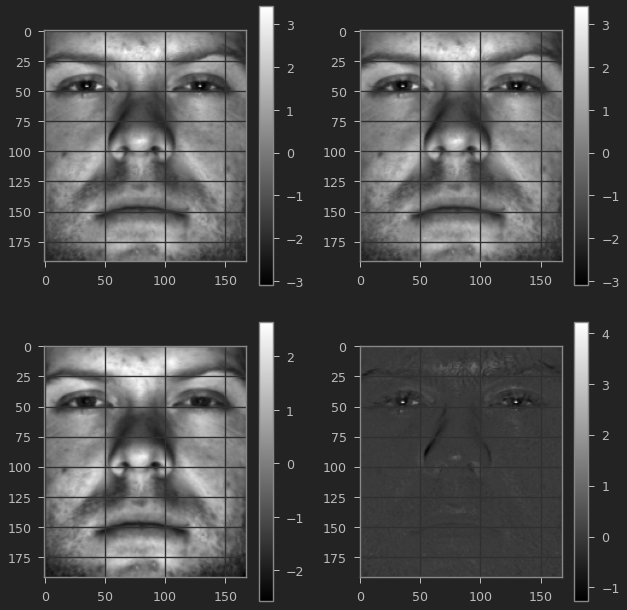

In [12]:
M = L + S
matrix_dst = de_standardise(matrix, means, stds)
M_dst = de_standardise(M, means, stds)
L_dst = de_standardise(L, means, stds)
S_scaled = S - np.min(S)
S_scaled = S / np.max(S_scaled)
index = 4
figure, (axis1, axis2) = plt.subplots(2, 2)
image1 = axis1[0].imshow(matrix[:, index].reshape((168, 192)).T, cmap='gray')
image2 = axis1[1].imshow(M[:, index].reshape((168, 192)).T, cmap='gray')
image3 = axis2[0].imshow(L[:, index].reshape((168, 192)).T, cmap='gray')
image4 = axis2[1].imshow(S[:, index].reshape((168, 192)).T, cmap='gray')
figure.colorbar(image1, ax=axis1[0])
figure.colorbar(image2, ax=axis1[1])
figure.colorbar(image3, ax=axis2[0])
figure.colorbar(image4, ax=axis2[1])
plt.tight_layout()
print(np.linalg.matrix_rank(L_dst), 1/2*np.linalg.norm(matrix_dst - M_dst, 'fro') ** 2)

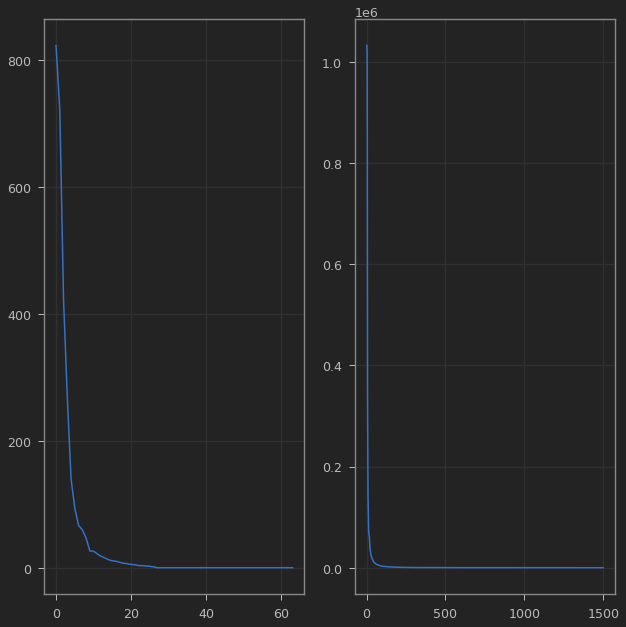

In [13]:
_, Sigma, _ = np.linalg.svd(L, full_matrices=0)
figure, axis = plt.subplots(1, 2)
axis[0].plot(Sigma)
axis[1].plot(sensitivities)
plt.tight_layout()

Now we perform accelerated approach and will observe its superiority

In [15]:
L_accelerated, S_accelerated, sensitivities_accelerated = robust_pca(matrix, acceleration=True)

Iteration [50/1500], sensitivity: 1648.6352/0.0103
Iteration [100/1500], sensitivity: 172.7911/0.0103
Iteration [150/1500], sensitivity: 25.1923/0.0103
Iteration [200/1500], sensitivity: 5.1457/0.0103
Iteration [250/1500], sensitivity: 1.3335/0.0103
Iteration [300/1500], sensitivity: 0.4431/0.0103
Iteration [350/1500], sensitivity: 0.1656/0.0103
Iteration [400/1500], sensitivity: 0.0753/0.0103
Iteration [450/1500], sensitivity: 0.0332/0.0103
Iteration [500/1500], sensitivity: 0.0175/0.0103
Completed after iteration [539/1500], sensitivity: 0.0102/0.0103


/tmp/ipykernel_30932/3355870007.py:13: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  figure.colorbar(image1, ax=axis1[0])
/tmp/ipykernel_30932/3355870007.py:14: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  figure.colorbar(image2, ax=axis1[1])
/tmp/ipykernel_30932/3355870007.py:15: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  figure.colorbar(image3, ax=axis2[0])
/tmp/ipykernel_30932/3355870007.py:16: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.

29 0.010233388548806817


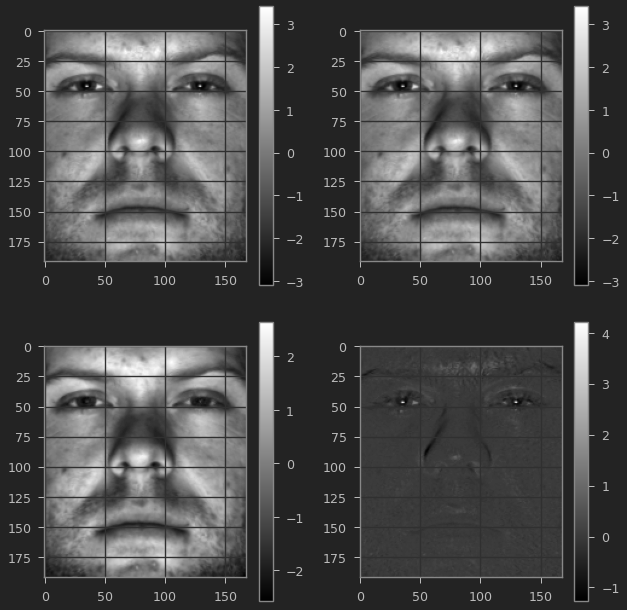

In [16]:
M_accelerated = L_accelerated + S_accelerated
X_dst = de_standardise(matrix, means, stds)
M_accelerated_dst = de_standardise(M_accelerated, means, stds)
L_accelerated_dst = de_standardise(L_accelerated, means, stds)
S_accelerated_scaled = S_accelerated - np.min(S_accelerated)
S_accelerated_scaled = S_accelerated / np.max(S_accelerated_scaled)
index = 4
figure, (axis1, axis2) = plt.subplots(2, 2)
image1 = axis1[0].imshow(matrix[:, index].reshape((168, 192)).T, cmap='gray')
image2 = axis1[1].imshow(M_accelerated[:, index].reshape((168, 192)).T, cmap='gray')
image3 = axis2[0].imshow(L_accelerated[:, index].reshape((168, 192)).T, cmap='gray')
image4 = axis2[1].imshow(S_accelerated[:, index].reshape((168, 192)).T, cmap='gray')
figure.colorbar(image1, ax=axis1[0])
figure.colorbar(image2, ax=axis1[1])
figure.colorbar(image3, ax=axis2[0])
figure.colorbar(image4, ax=axis2[1])
plt.tight_layout()
print(np.linalg.matrix_rank(L_accelerated), 1/2*np.linalg.norm(matrix - M_accelerated, 'fro') ** 2)

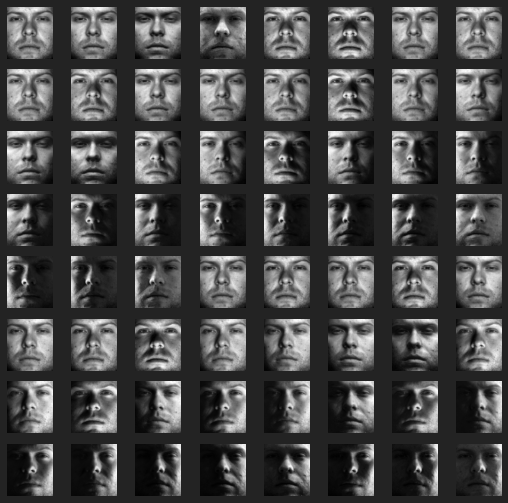

In [17]:
for counter in range(number_of_faces_per_person[0]):
    plt.subplot(8, 8, counter + 1)
    plt.imshow(L_accelerated[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout
plt.show()

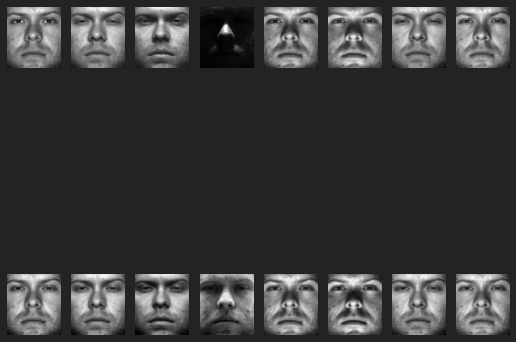

In [18]:
for counter in range(8):    
    plt.subplot(2, 8, counter + 1)
    plt.imshow(approximated_matrix[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
    plt.subplot(2, 8, counter + 9)
    plt.imshow(L_accelerated[:, counter].reshape((168, 192)).T, cmap='gray')
    plt.axis('off') 
plt.tight_layout   
plt.show()

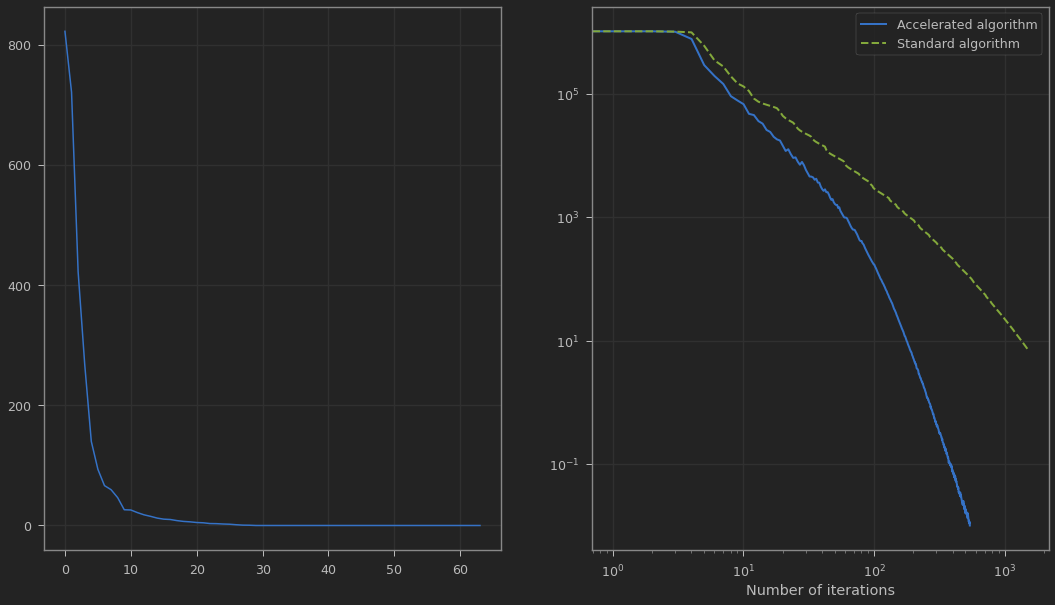

In [33]:
_, Sigma_accelerated, _ = np.linalg.svd(L_accelerated, full_matrices=0)

fig = plt.figure(figsize=(18, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(Sigma_accelerated)

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(np.linspace(0, len(sensitivities_accelerated), len(sensitivities_accelerated)), \
                        sensitivities_accelerated, linewidth=2, label='Accelerated algorithm')
ax2.plot(np.linspace(0, len(sensitivities), len(sensitivities)), sensitivities, '--', \
                        linewidth=2, label='Standard algorithm')

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('Number of iterations')
ax2.legend(loc='best')
plt.show()

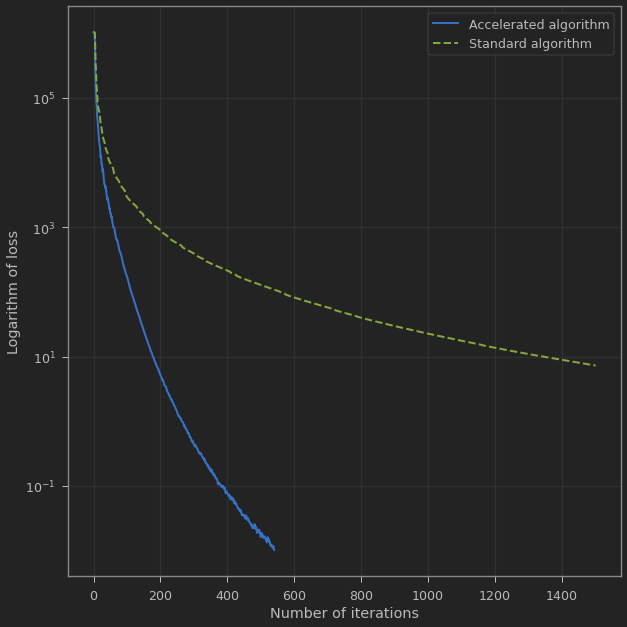

In [34]:
ax = plt.subplot()
line1 = ax.plot(np.linspace(0, len(sensitivities_accelerated), len(sensitivities_accelerated)), \
                        sensitivities_accelerated, linewidth=2, label='Accelerated algorithm')
line2 = ax.plot(np.linspace(0, len(sensitivities), len(sensitivities)), sensitivities, '--', \
                        linewidth=2, label='Standard algorithm')
ax.set_yscale('log')
ax.set_xlabel('Number of iterations')
ax.set_ylabel('Logarithm of loss')
ax.legend(loc='best')
plt.tight_layout()
plt.savefig('robust-PCA-convergence.pdf')
#plt.ylim((0, 20))
#plt.tight_layout()
plt.show()

Both plot shows clear primacy of accelerated method.